<a href="https://colab.research.google.com/github/am610/SN_lsst_analysis/blob/main/Ayan/2_Large_Data_CPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copied from :
# https://github.com/igomezv/SN_lsst_analysis/blob/main/Load_large_model.ipynb

In [2]:
! pip install astronn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.9/888.9 kB 71.6 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, euclidean_distances, median_absolute_error
import numpy as np
import pandas as pd
from astroNN.nn.layers import MCDropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import scipy.integrate as intg

In [26]:
!wget 'https://raw.githubusercontent.com/igomezv/SN_lsst_analysis/main/models/large_lsst_model.h5?token=GHSAT0AAAAAACCZYW3JGNVWJAVT6NWXIJCQZHFBMMA' -O large_lsst_model.h5


--2023-08-22 19:01:12--  https://raw.githubusercontent.com/igomezv/SN_lsst_analysis/main/models/large_lsst_model.h5?token=GHSAT0AAAAAACCZYW3JGNVWJAVT6NWXIJCQZHFBMMA
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1514112 (1.4M) [application/octet-stream]
Saving to: ‘large_lsst_model.h5’

large_lsst_model.h5 100%[===================>]   1.44M  --.-KB/s    in 0.01s   

2023-08-22 19:01:12 (121 MB/s) - ‘large_lsst_model.h5’ saved [1514112/1514112]



In [27]:
!wget https://raw.githubusercontent.com/igomezv/SN_lsst_analysis/main/Data_SNIa_LSST/larger/hubble_diagram.txt?token=GHSAT0AAAAAACCZYW3JO5SIRIBX6745TNC4ZHFBTDQ -O hubble_diagram.txt


--2023-08-22 19:01:13--  https://raw.githubusercontent.com/igomezv/SN_lsst_analysis/main/Data_SNIa_LSST/larger/hubble_diagram.txt?token=GHSAT0AAAAAACCZYW3JO5SIRIBX6745TNC4ZHFBTDQ
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358769 (350K) [text/plain]
Saving to: ‘hubble_diagram.txt’

hubble_diagram.txt  100%[===================>] 350.36K  --.-KB/s    in 0.005s  

2023-08-22 19:01:13 (70.0 MB/s) - ‘hubble_diagram.txt’ saved [358769/358769]



In [29]:
model = tf.keras.models.load_model('large_lsst_model.h5', custom_objects={'MCDropout': MCDropout})
df_data = pd.read_csv('hubble_diagram.txt', skiprows=5, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702


In [30]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS,errors
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796,0.13996
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720,0.16230
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771,0.13201
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717,0.15157
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702,0.13022


In [31]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [32]:
z_or = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values
zmin, zmax = np.min(z_or), np.max(z_or)

scalerz = StandardScaler()
scalerz.fit(z_or.reshape(-1,1))
# apply transform
z = scalerz.transform(z_or.reshape(-1,1))

# Generate test data
# test_batch_size = 500
test_batch_size = len(z)
x_test = z

mc_dropout_num = 100 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(z_or.reshape(-1,1)))
#     predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



181/181 [==============================] - 0s 2ms/step


In [33]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2

def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

# zmodel = np.linspace(0.01, 2.4, 100)
zmodel = z_or
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [34]:
len(prediction_mc_dropout[:,0]), len(x_test), len(zmodel)

(5785, 5785, 5785)

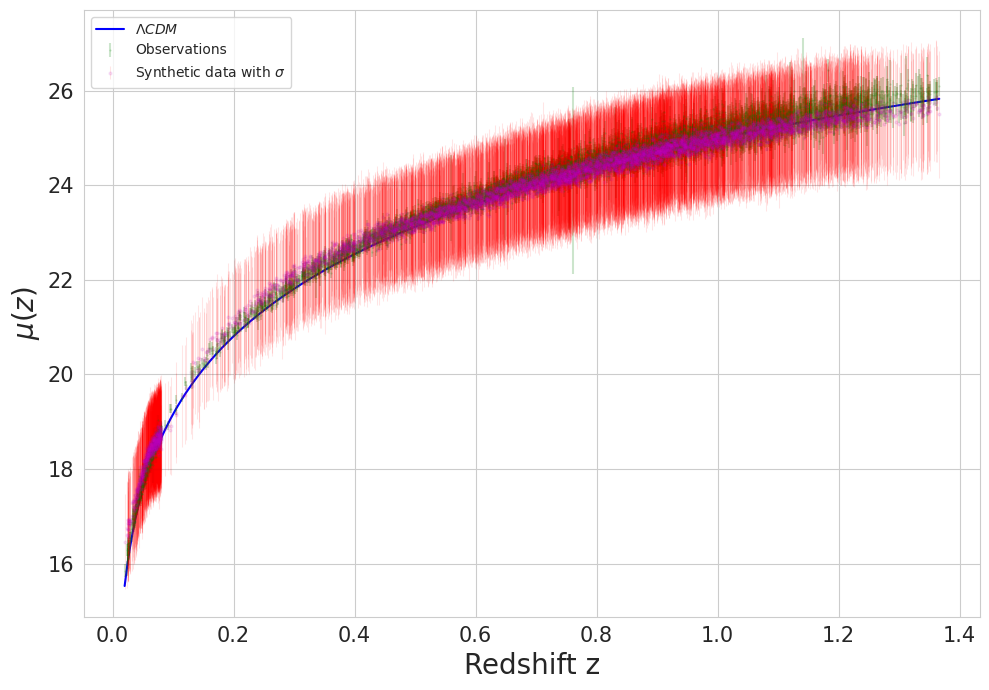

In [35]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=1, alpha=0.2, label='Observations')
plt.errorbar(z_or, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o',
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.1, c='m',
             label='Synthetic data with $\sigma$')

# plt.xlim(zmin-0.01,zmax+0.01)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

In [36]:
# mean_squared_error, euclidean_distances, median_absolute_error
mse_lcdm = mean_squared_error(df_data['MU'].values-19, flcdm)
mse_neural = mean_squared_error(df_data['MU'].values-19, np.sort(prediction_mc_dropout[:,0]-19))
mse_lcdm, mse_neural

(0.038229351086070555, 0.03805109859155617)

In [37]:
np.sort(prediction_mc_dropout[:,0])-19

array([16.4608968 , 16.53847343, 16.58107948, ..., 25.83896919,
       25.86683502, 25.87010265])

In [38]:
np.sort(df_data['MU'].values)-19

array([15.8468 , 15.89863, 16.09582, ..., 26.24313, 26.33098, 26.43075])

In [40]:
# Diagnosing the shapes of z_or and prediction_mc_dropout[0]
shape_z_or = z_or.shape
shape_prediction = prediction_mc_dropout[:,0].shape

shape_z_or, shape_prediction


((5785, 1), (5785,))

# CPL

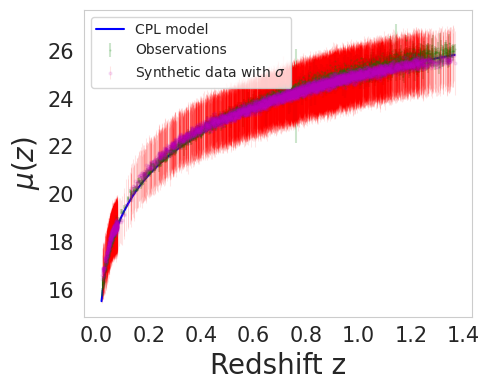

MSE for CPL model: 0.038229351086070555


In [49]:
# Define the CPL model functions
def RHSquared_a_cpl(a, w0, wa, Om):
    w = w0 + (1 - a) * wa
    rhow = a**(-3*(1.0+w))
    return (Om/a**3 + (1.0-Om)*rhow)

def DistIntegrand_a_cpl(a, w0, wa, Om):
    return 1./np.sqrt(RHSquared_a_cpl(a, w0, wa, Om))/a**2

def Da_z_cpl(z, w0, wa, Om):
    r = intg.quad(DistIntegrand_a_cpl, 1./(1+z), 1, args=(w0, wa, Om))
    return r[0]

def distance_modulus_cpl(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z_cpl(z, w0, wa, Om)*(1+z))+24

# Calculate the CPL model values
f_cpl = [distance_modulus_cpl(zzz[0], w0=-1, wa=0, Om=om) for zzz in z_or]

sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# Plotting with Seaborn
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
sns.despine(left=True)
plt.plot(z_or, f_cpl, label='CPL model', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=1, alpha=0.2, label='Observations')
plt.errorbar(z_or, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', ecolor='r', capthick=2, elinewidth=0.8, alpha=0.1, c='m', label='Synthetic data with $\sigma$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left')
plt.tight_layout()
plt.grid(False)

plt.show()
# Evaluate the CPL model
mse_cpl = mean_squared_error(df_data['MU'].values-19, f_cpl)
print("MSE for CPL model:", mse_cpl)


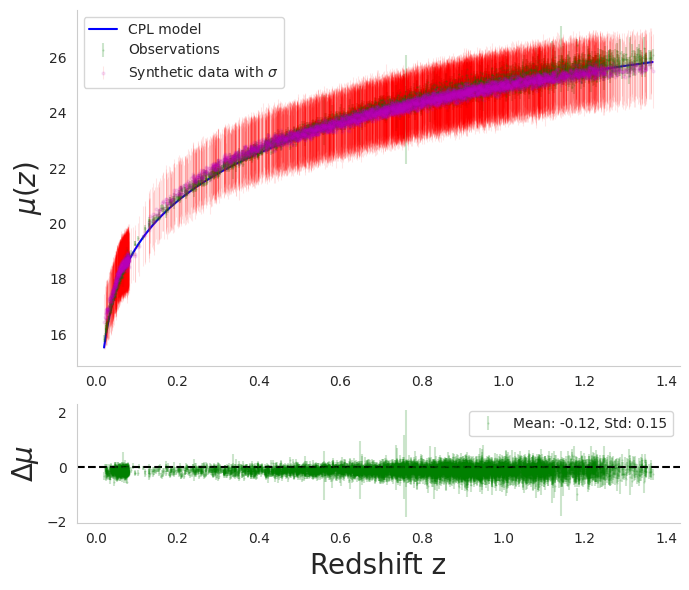

In [54]:
import matplotlib.gridspec as gridspec

# Calculate residuals for the CPL model
residuals_cpl = np.array(f_cpl) - (df_data['MU'].values - 19)
# Calculate mean and standard deviation of the residuals
mean_residuals = np.mean(residuals_cpl)
std_residuals = np.std(residuals_cpl)


# Create a gridspec for the main plot and the residuals
fig = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax_main = plt.subplot(gs[0])
ax_resid = plt.subplot(gs[1], sharex=ax_main)

# Main plot
ax_main.plot(z_or, f_cpl, label='CPL model', c='b')
ax_main.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=1, alpha=0.2, label='Observations')
ax_main.errorbar(z_or, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', ecolor='r', capthick=2, elinewidth=0.8, alpha=0.1, c='m', label='Synthetic data with $\sigma$')
ax_main.set_ylabel("$\mu(z)$", fontsize=20)
ax_main.legend(loc='upper left')
ax_main.grid(False)
sns.despine(ax=ax_main)

# Residual plot
ax_resid.errorbar(df_data['zCMB'], residuals_cpl, df_data['errors'], fmt='g.', markersize=1, alpha=0.2,label=f'Mean: {mean_residuals:.2f}, Std: {std_residuals:.2f}')
ax_resid.axhline(0, color='black', linestyle='--')  # Zero line for reference
ax_resid.set_xlabel("Redshift z", fontsize=20)
ax_resid.set_ylabel("$\Delta \mu$", fontsize=20)
ax_resid.grid(False)
sns.despine(ax=ax_resid)

# Adjust layout and show
plt.tight_layout()
plt.legend()
plt.show()


